<h2> Modelagem de Dados </h2>

Inclui as seguintes etapas:
1. Pré-processamento de dados. Tratamento de variáveis categóricas, numéricas. Escolha de possíveis features.
2. Divisão entre Treino e Teste.
3. Balançeamento.
4. Treinamentos de vários modelos. Técnica de validação cruzada.
5. Escolha do melhor modelo.
6. Avaliação de resultados.
7. Geração de previsões, base de teste
8. Otimização de hyperparâmetros.
9. Salvar modelo, objetos de transformação para inferência.

Importações de pacotes e bibliotecas

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Obs de alerta: o modelo foi treinado com a versão 1.0.2, enquanto o streamlit está ligeiramente. Configuração de ambiente a ser notada.

Definição de Funções

In [27]:
def converter_meses_ano(mes):
    return mes//12.008

Escopo Principal (Main)

Carregamento das bases de dados

In [28]:
# Obtenção das bases de dados
try:
    clientes_contratos_abt = pd.read_csv("../../bases/abt_contratos_clientes.csv")
    clientes_contratos_teste = pd.read_csv("../../bases/churn-20.csv") 
except Exception as excecao:
    print(f"Erro ao carregar as bases de dados!")
    print(excecao)
else:
    print(f"Base de dados lidas com sucesso!")

Base de dados lidas com sucesso!


In [29]:
clientes_contratos_abt.shape

(2666, 12)

In [30]:
clientes_contratos_abt

,State,Account_length_year,Area code,International plan,Voice mail plan,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn
0,KS,10.0,415,No,Yes,25,45.07,16.78,11.01,2.70,1,False
1,OH,8.0,415,No,Yes,26,27.47,16.62,11.45,3.70,1,False
2,NJ,11.0,415,No,No,0,41.38,10.30,7.32,3.29,0,False
3,OH,6.0,408,Yes,No,0,50.90,5.26,8.86,1.78,2,False
4,OK,6.0,415,Yes,No,0,28.34,12.61,8.41,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,6.0,415,No,No,0,22.90,16.12,9.96,3.19,2,False
2662,AZ,15.0,415,No,Yes,36,26.55,18.32,12.56,2.67,2,False
2663,WV,5.0,415,No,No,0,39.29,13.04,8.61,2.59,3,False
2664,RI,2.0,510,No,No,0,30.74,24.55,8.64,3.81,2,False


Tratamento das Variáveis Categóricas

In [31]:
# Convertendo de int para str
clientes_contratos_abt['Area code'] = clientes_contratos_abt['Area code'].astype(str)
clientes_contratos_abt['Area code']

0       415
1       415
2       415
3       408
4       415
       ... 
2661    415
2662    415
2663    415
2664    510
2665    415
Name: Area code, Length: 2666, dtype: object

In [32]:
clientes_contratos_cat = clientes_contratos_abt[['State','Area code','International plan','Voice mail plan']]
print(f"Qtde de variáveis categóricas ANTES do PROCESSAMENTO {len(clientes_contratos_cat.columns)}")
print(f"Variáveis categóricas {clientes_contratos_cat.columns}")

Qtde de variáveis categóricas ANTES do PROCESSAMENTO 4
Variáveis categóricas Index(['State', 'Area code', 'International plan', 'Voice mail plan'], dtype='object')


In [33]:
clientes_contratos_cat_dump = pd.get_dummies(clientes_contratos_cat)
print(f"Qtde de variáveis categóricas APÓS O PROCESSAMENTO {len(clientes_contratos_cat_dump.columns)}")
clientes_contratos_cat_dump


Qtde de variáveis categóricas APÓS O PROCESSAMENTO 58


,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,...,State_WI,State_WV,State_WY,Area code_408,Area code_415,Area code_510,International plan_No,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
2662,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True
2663,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,True,False,True,False
2664,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,True,False


Tratamento das Variáveis Quantitivas

In [34]:
clientes_contratos_quantitativas = clientes_contratos_abt[['Account_length_year','Number vmail messages','Total day charge',
                                                 'Total eve charge', 'Total night charge', 'Total intl charge',
                                                 'Customer service calls']]
print(f"Qtde de variáveis quantitativas ANTES do PROCESSAMENTO {len(clientes_contratos_quantitativas.columns)}")
print(f"Variáveis quantitativas {clientes_contratos_quantitativas.columns}")
# Poderíamos aplicar normalização, porém a ESCALA não é tão significativa de grande e algoritmos escolhidos não são sensíveis a isso.

Qtde de variáveis quantitativas ANTES do PROCESSAMENTO 7
Variáveis quantitativas Index(['Account_length_year', 'Number vmail messages', 'Total day charge',
       'Total eve charge', 'Total night charge', 'Total intl charge',
       'Customer service calls'],
      dtype='object')


Tratamento da TARGET

In [35]:
le = LabelEncoder()
clientes_contratos_abt['Churn_tratada'] = le.fit_transform(clientes_contratos_abt['Churn'])
clientes_contratos_abt[['Churn','Churn_tratada']]

,Churn,Churn_tratada
0,False,0
1,False,0
2,False,0
3,False,0
4,False,0
...,...,...
2661,False,0
2662,False,0
2663,False,0
2664,False,0


In [36]:
# Caso precise fazer o DE-PARA
#le.inverse_transform

Junções de categóricas e quantitivas

In [37]:
# Acrestamos também as chaves de cliente e contrato, mm-dd para posteior análise. mm-dd será usado para TREINO E TESTE.
var_qualitativas_quantitivas_target = pd.concat([clientes_contratos_cat_dump,clientes_contratos_quantitativas,clientes_contratos_abt[['Churn_tratada']]], axis=1)
print(f"Qtde de variáveis totais {len(var_qualitativas_quantitivas_target.columns)}")
var_qualitativas_quantitivas_target

Qtde de variáveis totais 66


,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,...,Voice mail plan_No,Voice mail plan_Yes,Account_length_year,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn_tratada
0,False,False,False,False,False,False,False,False,False,False,...,False,True,10.0,25,45.07,16.78,11.01,2.70,1,0
1,False,False,False,False,False,False,False,False,False,False,...,False,True,8.0,26,27.47,16.62,11.45,3.70,1,0
2,False,False,False,False,False,False,False,False,False,False,...,True,False,11.0,0,41.38,10.30,7.32,3.29,0,0
3,False,False,False,False,False,False,False,False,False,False,...,True,False,6.0,0,50.90,5.26,8.86,1.78,2,0
4,False,False,False,False,False,False,False,False,False,False,...,True,False,6.0,0,28.34,12.61,8.41,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,False,False,False,False,False,False,False,False,False,False,...,True,False,6.0,0,22.90,16.12,9.96,3.19,2,0
2662,False,False,False,True,False,False,False,False,False,False,...,False,True,15.0,36,26.55,18.32,12.56,2.67,2,0
2663,False,False,False,False,False,False,False,False,False,False,...,True,False,5.0,0,39.29,13.04,8.61,2.59,3,0
2664,False,False,False,False,False,False,False,False,False,False,...,True,False,2.0,0,30.74,24.55,8.64,3.81,2,0


Divisão entre X(features) e Y(target)

In [38]:
abt_x_treino = var_qualitativas_quantitivas_target
abt_x_treino = abt_x_treino.drop(columns = 'Churn_tratada')
abt_y_treino = var_qualitativas_quantitivas_target[['Churn_tratada']]

Tratamento da base de teste para previsões

In [39]:
clientes_contratos_teste.shape

(667, 20)

In [40]:
clientes_contratos_teste.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [41]:
# Criação da coluna Account_length_year
# Tratamento da TARGET
# Tratamento das variáveis categóricas
# Tratamento das variáveis quantitativas

In [42]:
# Criando variável:Account length year para fins de observação
clientes_contratos_teste['Account_length_year'] = clientes_contratos_teste['Account length'].apply(converter_meses_ano)
clientes_contratos_teste[['Account length','Account_length_year']].head(5)

,Account length,Account_length_year
0,117,9.0
1,65,5.0
2,161,13.0
3,111,9.0
4,49,4.0


In [43]:
# Tratamento da TARGET
le = LabelEncoder()
clientes_contratos_teste['Churn_tratada'] = le.fit_transform(clientes_contratos_teste['Churn'])
clientes_contratos_teste[['Churn','Churn_tratada']]

,Churn,Churn_tratada
0,False,0
1,True,1
2,True,1
3,False,0
4,False,0
...,...,...
662,False,0
663,False,0
664,False,0
665,False,0


In [44]:
# Tratamento das variáveis categóricas
clientes_contratos_cat_base_teste = clientes_contratos_teste[['State','Area code','International plan','Voice mail plan']]
print(f"Qtde de variáveis categóricas ANTES do PROCESSAMENTO {len(clientes_contratos_cat_base_teste.columns)}")
print(f"Variáveis categóricas {clientes_contratos_cat_base_teste.columns}")

Qtde de variáveis categóricas ANTES do PROCESSAMENTO 4
Variáveis categóricas Index(['State', 'Area code', 'International plan', 'Voice mail plan'], dtype='object')


In [45]:
clientes_contratos_cat_base_teste['Area code'] = clientes_contratos_cat_base_teste['Area code'].astype(str)
clientes_contratos_cat_base_teste['Area code']

C:\Users\roger\AppData\Local\Temp\ipykernel_8448\3327188375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_contratos_cat_base_teste['Area code'] = clientes_contratos_cat_base_teste['Area code'].astype(str)


0      408
1      415
2      415
3      415
4      510
      ... 
662    415
663    408
664    415
665    415
666    510
Name: Area code, Length: 667, dtype: object

In [46]:
# Tratamento das variáveis categóricas
clientes_contratos_cat_dump_base_teste = pd.get_dummies(clientes_contratos_cat_base_teste)
print(f"Qtde de variáveis categóricas APÓS O PROCESSAMENTO {len(clientes_contratos_cat_dump_base_teste.columns)}")
clientes_contratos_cat_dump_base_teste


Qtde de variáveis categóricas APÓS O PROCESSAMENTO 58


,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,...,State_WI,State_WV,State_WY,Area code_408,Area code_415,Area code_510,International plan_No,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,True,False,False,True
663,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
664,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
665,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,True,False,True,False,True,False


In [47]:
# Tratamento das variáveis quantitativas
clientes_contratos_quantitativas_base_teste = clientes_contratos_teste[['Account_length_year','Number vmail messages','Total day charge',
                                                 'Total eve charge', 'Total night charge', 'Total intl charge',
                                                 'Customer service calls']]
print(f"Qtde de variáveis quantitativas ANTES do PROCESSAMENTO {len(clientes_contratos_quantitativas_base_teste.columns)}")
print(f"Variáveis quantitativas {clientes_contratos_quantitativas_base_teste.columns}")
# Poderíamos aplicar normalização, porém a ESCALA não é tão significativa de grande e algoritmos escolhidos não são sensíveis a isso.

Qtde de variáveis quantitativas ANTES do PROCESSAMENTO 7
Variáveis quantitativas Index(['Account_length_year', 'Number vmail messages', 'Total day charge',
       'Total eve charge', 'Total night charge', 'Total intl charge',
       'Customer service calls'],
      dtype='object')


In [48]:
# Junção das categóricas e quantitativas
var_qualitativas_quantitivas_target_base_teste = pd.concat([clientes_contratos_cat_dump_base_teste,clientes_contratos_quantitativas_base_teste,clientes_contratos_teste[['Churn_tratada']]], axis=1)
print(f"Qtde de variáveis totais {len(var_qualitativas_quantitivas_target_base_teste.columns)}")
var_qualitativas_quantitivas_target_base_teste

Qtde de variáveis totais 66


,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,...,Voice mail plan_No,Voice mail plan_Yes,Account_length_year,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Churn_tratada
0,False,False,False,False,False,False,False,False,False,False,...,True,False,9.0,0,31.37,29.89,9.71,2.35,1,0
1,False,False,False,False,False,False,False,False,False,False,...,True,False,5.0,0,21.95,19.42,9.40,3.43,4,1
2,False,False,False,False,False,False,False,False,False,False,...,True,False,13.0,0,56.59,27.01,7.23,1.46,4,1
3,False,False,False,False,False,False,False,False,False,False,...,True,False,9.0,0,18.77,11.67,8.53,2.08,2,0
4,False,False,False,False,False,False,False,False,False,False,...,True,False,4.0,0,20.28,18.28,8.04,3.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,False,False,False,False,False,False,False,False,False,False,...,False,True,9.0,26,23.31,13.23,11.14,3.11,2,0
663,False,True,False,False,False,False,False,False,False,False,...,False,True,8.0,29,14.21,17.33,10.33,2.19,1,0
664,False,False,False,False,False,False,False,False,False,False,...,True,False,4.0,0,32.96,7.23,9.45,3.56,3,0
665,False,False,False,False,False,False,False,False,False,False,...,True,False,13.0,0,28.87,16.80,8.72,3.13,1,0


In [49]:
# Divisão de X e Y na base de teste
abt_x_teste = var_qualitativas_quantitivas_target_base_teste
abt_x_teste = abt_x_teste.drop(columns = 'Churn_tratada')
abt_y_teste = var_qualitativas_quantitivas_target_base_teste[['Churn_tratada']]

Balançeamento apenas da BASE DE TREINO

In [50]:
# A base carregada em questão é A BASE DE TREINAMENTO. abt_contratos_clientes

In [51]:
# Verificando a distribuição das classes
total_amostras = len(var_qualitativas_quantitivas_target)
print(f"Qtde de CLASSE 0 NÃO DESISTENTE: {len(var_qualitativas_quantitivas_target[var_qualitativas_quantitivas_target.Churn_tratada == 0.0])}")
print(f"Qtde de CLASSE 1 DESISTENTE : {len(var_qualitativas_quantitivas_target[var_qualitativas_quantitivas_target.Churn_tratada == 1.0])}")
print(f"Qtde de REGISTROS TOTAIS : {total_amostras}")
print(f"% de CLASSE 0 NÃO DESISTENTE: {len(var_qualitativas_quantitivas_target[var_qualitativas_quantitivas_target.Churn_tratada == 0.0])/total_amostras  * 100}")
print(f"% de CLASSE 1 DESISTENTE : {len(var_qualitativas_quantitivas_target[var_qualitativas_quantitivas_target.Churn_tratada == 1.0])/total_amostras  * 100}")


Qtde de CLASSE 0 NÃO DESISTENTE: 2278
Qtde de CLASSE 1 DESISTENTE : 388
Qtde de REGISTROS TOTAIS : 2666
% de CLASSE 0 NÃO DESISTENTE: 85.4463615903976
% de CLASSE 1 DESISTENTE : 14.553638409602401


In [52]:
# Aplicaremos UNDERSAMPLING visto que a classe 1.0 (interesse) é bem menor que a classe 0. Logo reduziremos as amostras da classe 0 para igualar ambas.
# Testaremos o algoritmo balançeando e não balançeando.
print("=================================================================================")
rus = RandomUnderSampler(random_state=7)
# Será gerado uma nova base de treinamento
X_resampled, y_resampled = rus.fit_resample(abt_x_treino, abt_y_treino)
# Verificar a distribuição das classes antes e após o undersampling
print(f"Distribuição das classes 0 ANTES do undersampling CLASSE 0 {len(abt_y_treino[abt_y_treino.Churn_tratada == 0.0])}")
print(f"Distribuição das classes 1 ANTES do undersampling CLASSE 1 {len(abt_y_treino[abt_y_treino.Churn_tratada == 1.0])}")
print("=================================================================================")
print(f"Distribuição das classes 0 APÓS o undersampling CLASSE 0 {len(y_resampled[y_resampled.Churn_tratada == 0.0])}")
print(f"Distribuição das classes 1 APÓS o undersampling CLASSE 1 {len(y_resampled[y_resampled.Churn_tratada == 1.0])}")

Distribuição das classes 0 ANTES do undersampling CLASSE 0 2278
Distribuição das classes 1 ANTES do undersampling CLASSE 1 388
Distribuição das classes 0 APÓS o undersampling CLASSE 0 388
Distribuição das classes 1 APÓS o undersampling CLASSE 1 388


Treinamento de algoritmos

In [53]:
# Ajustando os dados para usar o extremeGBT
# abt_X_train, abt_X_test, abt_y_train, abt_y_test
dtrain = xgb.DMatrix(X_resampled, label=y_resampled.values.ravel())
dtest = xgb.DMatrix(abt_x_teste, label=abt_y_teste)
print("Preparando os datasets para o xGBT")

Preparando os datasets para o xGBT


In [54]:
# Configuração do algoritmo xGBT
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.1
}
print("Configuração para o xGBT pronta")

Configuração para o xGBT pronta


In [55]:
%%time
# Utilizaremos 3 modelos para treinar e avaliaremos qual apresenta o melhor resultado.

# Inicializando os modelos
decision_tree_modelo = DecisionTreeClassifier()
random_forest_modelo = RandomForestClassifier()

# # Treinando os modelos
decision_tree_modelo.fit(X_resampled, y_resampled.values.ravel())
random_forest_modelo.fit(X_resampled, y_resampled.values.ravel())
xgbt_modelo = xgb.train(params, dtrain, num_boost_round=100)
print("Treinando os modelos")

Treinando os modelos
CPU times: total: 1.69 s
Wall time: 684 ms


Efetuando previsões

In [56]:
abt_x_teste

,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,...,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes,Account_length_year,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,9.0,0,31.37,29.89,9.71,2.35,1
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,5.0,0,21.95,19.42,9.40,3.43,4
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,13.0,0,56.59,27.01,7.23,1.46,4
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,9.0,0,18.77,11.67,8.53,2.08,2
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,4.0,0,20.28,18.28,8.04,3.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,False,False,False,False,False,False,False,False,False,False,...,False,False,True,9.0,26,23.31,13.23,11.14,3.11,2
663,False,True,False,False,False,False,False,False,False,False,...,False,False,True,8.0,29,14.21,17.33,10.33,2.19,1
664,False,False,False,False,False,False,False,False,False,False,...,False,True,False,4.0,0,32.96,7.23,9.45,3.56,3
665,False,False,False,False,False,False,False,False,False,False,...,False,True,False,13.0,0,28.87,16.80,8.72,3.13,1


In [57]:
# logistic_previsoes = logistic_modelo.predict(abt_X_test)
decision_tree_previsoes = decision_tree_modelo.predict(abt_x_teste)
random_forest_previsoes = random_forest_modelo.predict(abt_x_teste)
# Previsões em forma de probabilidade
xgbt_modelo_previsoes = xgbt_modelo.predict(dtest)
xgbt_modelo_previsoes_probabilidades = xgbt_modelo_previsoes
# Converter previsões para 0 ou 1 as previsões do xgbt
xgbt_modelo_previsoes = (xgbt_modelo_previsoes > 0.5).astype(int)
print("Efetuando previsões ")

Efetuando previsões 


Avaliação de Resultados

In [58]:
# Avaliando o desempenho e retornando o melhor
f1_score_model_decision = f1_score(abt_y_teste, decision_tree_previsoes)
f1_score_model_random = f1_score(abt_y_teste, random_forest_previsoes)
f1_score_model_xgbt = f1_score(abt_y_teste, xgbt_modelo_previsoes)

# Escolheremos o modelo modelo se baseando na métrica F1-score, ou seja, o que tiver maior VALOR. Estamos considerando somente a classe 1
metricas_f1_modelos = {'decision':f1_score_model_decision,
                       'random':f1_score_model_random,
                       'xgbt':f1_score_model_xgbt}

print(f"Métricas F1 {metricas_f1_modelos}")
print(f"Melhor métrica F1-Score foi {max(metricas_f1_modelos)}")
print("================================================================================")
print("Modelo DecisionTree")
print(classification_report(abt_y_teste, decision_tree_previsoes, labels=[0,1]))

print("================================================================================")
print("Modelo RandomForest")
print(classification_report(abt_y_teste, random_forest_previsoes, labels=[0,1]))

print("================================================================================")
print("Modelo xGBT")
print(classification_report(abt_y_teste, xgbt_modelo_previsoes, labels=[0,1]))

Métricas F1 {'decision': 0.5031847133757962, 'random': 0.6558704453441295, 'xgbt': 0.6557377049180327}
Melhor métrica F1-Score foi xgbt
Modelo DecisionTree
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       572
           1       0.36      0.83      0.50        95

    accuracy                           0.77       667
   macro avg       0.66      0.79      0.68       667
weighted avg       0.88      0.77      0.80       667

Modelo RandomForest
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       572
           1       0.53      0.85      0.66        95

    accuracy                           0.87       667
   macro avg       0.75      0.86      0.79       667
weighted avg       0.91      0.87      0.88       667

Modelo xGBT
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       572
           1       0.54      0.84      0.66      

Importância das FEATURES

<Axes: title={'center': 'Importância das Features - Modelo xgbt'}, xlabel='Valor do F-score', ylabel='Features'>

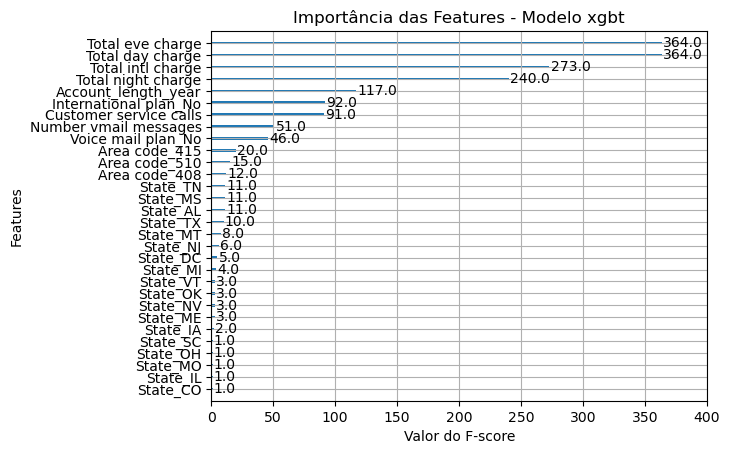

In [59]:
plot_importance(xgbt_modelo,title='Importância das Features - Modelo xgbt',xlabel='Valor do F-score', ylabel='Features')

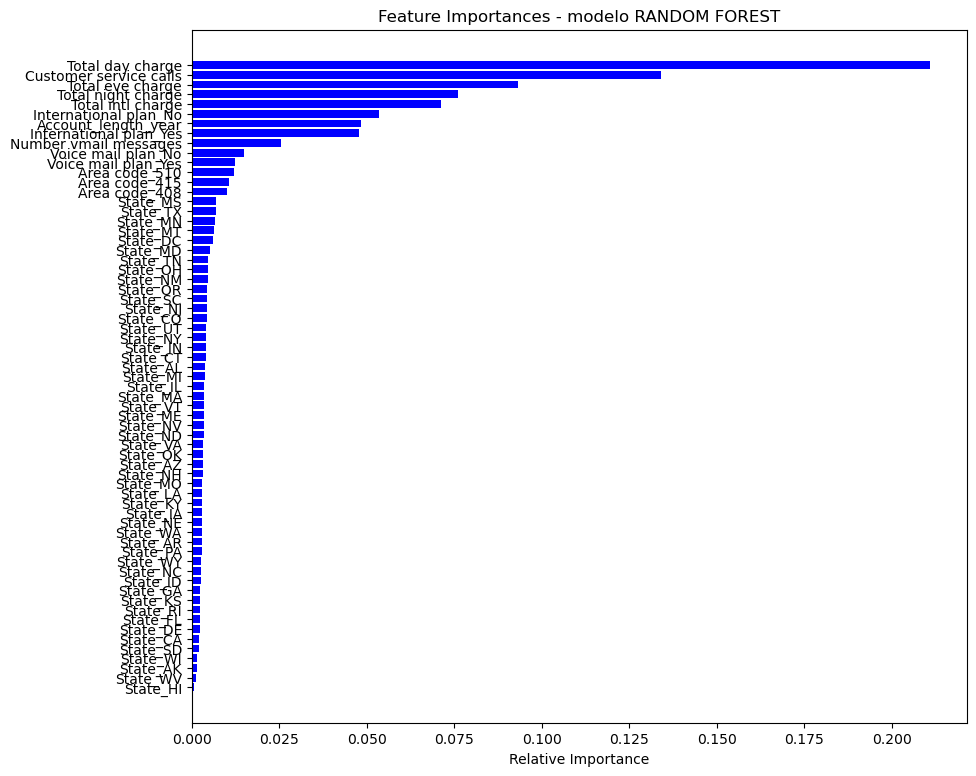

In [60]:
# Feature importance RANDOM
features = abt_x_teste.columns
importances = random_forest_modelo.feature_importances_
indices = np.argsort(importances)
fig = plt.figure(figsize=(10, 9))
plt.title('Feature Importances - modelo RANDOM FOREST')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Matriz de Confusão

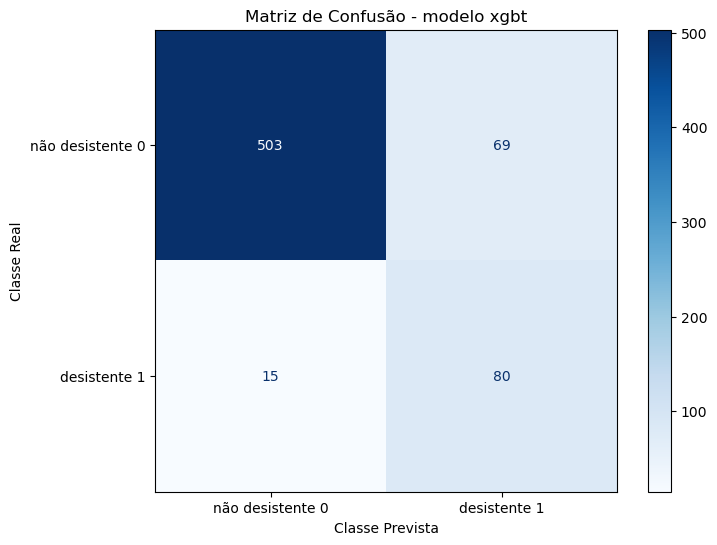

In [61]:
# Calcule a matriz de confusão
target_names = ['não desistente 0','desistente 1']
cm = confusion_matrix(abt_y_teste, xgbt_modelo_previsoes, labels=np.arange(len(target_names)))

# Plote a matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Matriz de Confusão - modelo xgbt')
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()

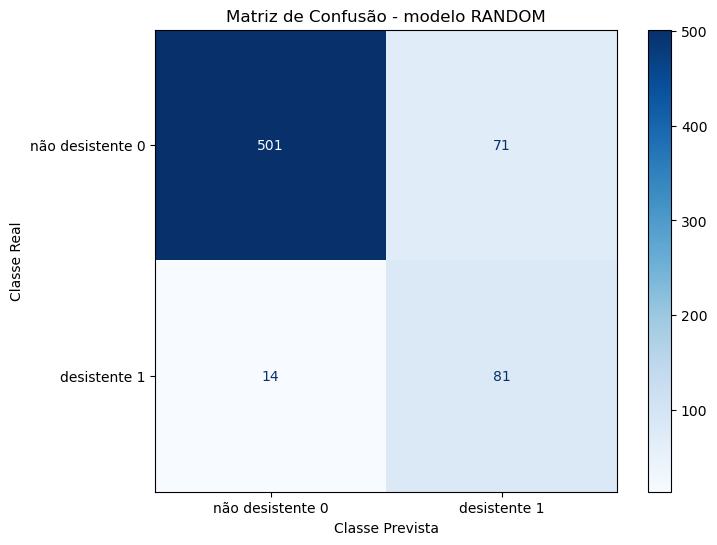

In [62]:
# Calcule a matriz de confusão
target_names = ['não desistente 0','desistente 1']
cm = confusion_matrix(abt_y_teste, random_forest_previsoes, labels=np.arange(len(target_names)))

# Plote a matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Matriz de Confusão - modelo RANDOM')
plt.xlabel("Classe Prevista")
plt.ylabel("Classe Real")
plt.show()

Curva ROC

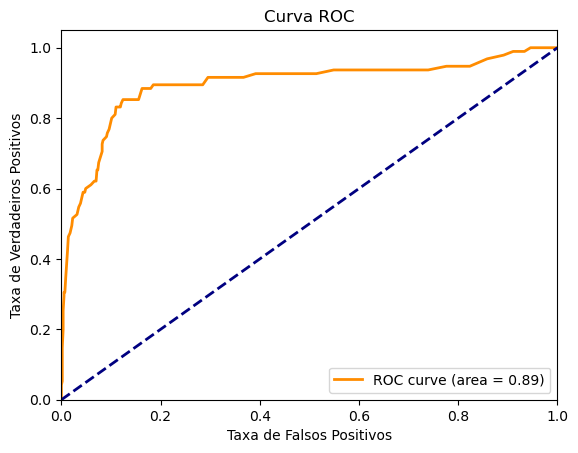

In [63]:
# Prever as probabilidades de pertencimento à classe positiva
y_prob = random_forest_modelo.predict_proba(abt_x_teste)[:, 1]  # Probabilidade para a classe positiva

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(abt_y_teste, y_prob)

# Calcular a AUC (Área Sob a Curva)
roc_auc = roc_auc_score(abt_y_teste, y_prob)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Otimização de hyperparâmetros </br>
Modelo RANDOM é o campeão. Embora as métricas do xgboost estejam melhores comparado ao RANDOM, optaremos pela RANDOM pela melhor distribuição de variáveis.

Parâmetros do modelo treinado

In [64]:
print(f"Features utilizadas ao total: {len(abt_x_treino.columns)}")
print(abt_x_treino.columns)

Features utilizadas ao total: 65
Index(['State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
       'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI',
       'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY',
       'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN',
       'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE',
       'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH',
       'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD',
       'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA',
       'State_WI', 'State_WV', 'State_WY', 'Area code_408', 'Area code_415',
       'Area code_510', 'International plan_No', 'International plan_Yes',
       'Voice mail plan_No', 'Voice mail plan_Yes', 'Account_length_year',
       'Number vmail messages', 'Total day charge', 'Total eve charge',
       'Total night charge', 'Total 

In [65]:
random_forest_modelo.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [66]:
# Opcionalmente podemos salvar as FEATURES juntamente com as configurações do modelo (parâmetros utilizados)

In [321]:
# Definindo o modelo
random_forest_estimador_v2 = RandomForestClassifier()

# Definindo o espaço de busca
param_grid = {
    'n_estimators': [30, 45, 70, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5,7,10],
    'min_samples_split': [3, 5, 10, 15], # número mínimo de samples(amostras) necessário para dividir um nó interno
    'min_samples_leaf': [3, 5, 7, 9]} # número mínimo de amostras que deve existir em cada folha

In [295]:
%%time
# Ajustando o modelo
grid_search.fit(X_resampled, y_resampled.values.ravel())
# Resultados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)
print("Melhor pontuação:")
print(grid_search.best_score_)
print("Modelo Treinado")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Melhores parâmetros encontrados:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 30}
Melhor pontuação:
0.8479239040529363
Modelo Treinado
CPU times: total: 14 s
Wall time: 1min 41s


c:\Users\roger\.conda\envs\churn_proj\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
960 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
363 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\roger\.conda\envs\churn_proj\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\roger\.conda\envs\churn_proj\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\roger\.conda\envs\churn_proj\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constrai

In [300]:
# Melhor modelo encontrado
random_forest_estimador_v2_otimizado = grid_search.best_estimator_
random_forest_estimador_v2_otimizado

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=3,
                       n_estimators=30)

In [305]:
# Previsões
random_forest_previsoes_v2 = random_forest_estimador_v2_otimizado.predict(abt_x_teste)
print("Efetuando previsões ")

Efetuando previsões 


In [306]:
# Resultados Finais
f1_score_model_random = f1_score(abt_y_teste, random_forest_previsoes)
f1_score_model_random_v2 = f1_score(abt_y_teste, random_forest_previsoes_v2)

metricas_f1_modelos = {'random':f1_score_model_random,'random_otimizado':f1_score_model_xgbt}

print(f"Métricas F1 {metricas_f1_modelos}")
print(f"Melhor métrica F1-Score foi {max(metricas_f1_modelos)}")
print("================================================================================")

print("================================================================================")
print("Modelo RandomForest")
print(classification_report(abt_y_teste, random_forest_previsoes, labels=[0,1]))

print("================================================================================")
print("Modelo RandomForest com ajuste de hyperparâmetros")
print(classification_report(abt_y_teste, random_forest_previsoes_v2, labels=[0,1]))

Métricas F1 {'random': 0.6428571428571429, 'random_otimizado': 0.6557377049180327}
Melhor métrica F1-Score foi random_otimizado
Modelo RandomForest
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       572
           1       0.52      0.85      0.64        95

    accuracy                           0.87       667
   macro avg       0.74      0.86      0.78       667
weighted avg       0.91      0.87      0.88       667

Modelo RandomForest com ajuste de hyperparâmetros
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       572
           1       0.51      0.77      0.62        95

    accuracy                           0.86       667
   macro avg       0.74      0.82      0.77       667
weighted avg       0.89      0.86      0.87       667



Salvando o modelo final

In [56]:
# Note que o modelo anterior, primeira versão, está melhor. Logo optaremos por ele
with open('random_forest_modelo_v1.pkl','wb') as f:
    pickle.dump(random_forest_modelo,f)
    print("Modelo salvo")

Modelo salvo


In [57]:
# Carregando o modelo, teste
with open('random_forest_modelo_v1.pkl', 'rb') as f:
    random_forest_modelo_carregado = pickle.load(f)
    print("Modelo carregado")
    print(type(random_forest_modelo_carregado))

Modelo carregado
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


Salvando as previsões finais

In [67]:
cli_contratos_previsoes_final = pd.concat([abt_x_teste,pd.DataFrame(random_forest_previsoes)], axis=1)
cli_contratos_previsoes_final = cli_contratos_previsoes_final.rename({0: 'Previsao'}, axis=1)
cli_contratos_previsoes_final

,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,...,Voice mail plan_No,Voice mail plan_Yes,Account_length_year,Number vmail messages,Total day charge,Total eve charge,Total night charge,Total intl charge,Customer service calls,Previsao
0,False,False,False,False,False,False,False,False,False,False,...,True,False,9.0,0,31.37,29.89,9.71,2.35,1,0
1,False,False,False,False,False,False,False,False,False,False,...,True,False,5.0,0,21.95,19.42,9.40,3.43,4,1
2,False,False,False,False,False,False,False,False,False,False,...,True,False,13.0,0,56.59,27.01,7.23,1.46,4,1
3,False,False,False,False,False,False,False,False,False,False,...,True,False,9.0,0,18.77,11.67,8.53,2.08,2,0
4,False,False,False,False,False,False,False,False,False,False,...,True,False,4.0,0,20.28,18.28,8.04,3.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,False,False,False,False,False,False,False,False,False,False,...,False,True,9.0,26,23.31,13.23,11.14,3.11,2,0
663,False,True,False,False,False,False,False,False,False,False,...,False,True,8.0,29,14.21,17.33,10.33,2.19,1,0
664,False,False,False,False,False,False,False,False,False,False,...,True,False,4.0,0,32.96,7.23,9.45,3.56,3,0
665,False,False,False,False,False,False,False,False,False,False,...,True,False,13.0,0,28.87,16.80,8.72,3.13,1,0


In [68]:
lista_features = list(cli_contratos_previsoes_final.columns)
f = open("features_name.txt", "w")
f.write(str(lista_features))
print(f"Arquivo de features salvo")
f.close()

Arquivo de features salvo


In [69]:
cli_contratos_previsoes_final.to_csv("../../bases/cli_contratos_previsoes_final.csv",index=False)
print("Base de previsões salva com sucesso")

Base de previsões salva com sucesso


Sugestões de testes.
1. Remoção de valores outliers.
2. Remoção de variáveis categóricas.
3. SMOTH para balancear.
4. Normalização de dados.
5. Encoding diferente ao invés de DUMP.